<a href="https://colab.research.google.com/github/oghenerosiloko/Chicago-Crime-Rate-Prediction/blob/main/Crime_Rate_Prediction_in_Chicago.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **CRIME RATE PREDICTION IN CHICAGO**


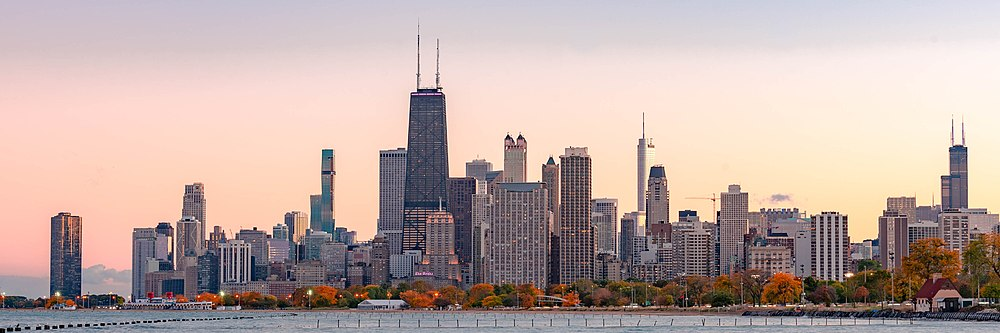

This dataset reflects reported incidents of crime (with the exception of murders where data exists for each victim) that occurred in the City of Chicago from 2001 to Nov 2018. Data is extracted from the Chicago Police Department's CLEAR (Citizen Law Enforcement Analysis and Reporting) system. In order to protect the privacy of crime victims, addresses are shown at the block level only and specific locations are not identified. 
[To read more about the Data, check Kaggle](https://www.kaggle.com/spirospolitis/chicago-crimes-20012018-november) 

[Image Source](https://en.wikipedia.org/wiki/Chicago)

**Overview**

   

The aim of this analysis is to use Facebook Prophet to predict the crime rate in chicago city for the next 365 days with the help of the huge historical data present for this analysis.

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. Prophet works best with time series that have strong seasonal effects and several seasons of historical data. 










**Contents**


*   Importation of Libraries

*   Data Preparation and Cleaning
*   Data Exploration
*   Forecast



In [ ]:
#Pip Install Kaggle because the data will be extracted from kaggle
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"silokooghenero","key":"81e0a20afe90bedcf6223776fa76167a"}'}

In [ ]:
#kaggle folder
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#Download data into google drive
!kaggle datasets download -d spirospolitis/chicago-crimes-20012018-november

 96% 361M/377M [00:03<00:00, 96.9MB/s]
100% 377M/377M [00:03<00:00, 124MB/s] 


In [ ]:
#Unzip Folder
!unzip chicago-crimes-20012018-november.zip

Archive:  chicago-crimes-20012018-november.zip
  inflating: city_of_chicago_crimes_2001_to_present.csv  


**Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [ ]:
#Copy data into a Variable
chicagodf= pd.read_csv('/content/city_of_chicago_crimes_2001_to_present.csv')

In [ ]:
chicagodf.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10000092,HY189866,03/18/2015 07:44:00 PM,047XX W OHIO ST,041A,BATTERY,AGGRAVATED: HANDGUN,STREET,False,False,1111,11.0,28.0,25.0,04B,1144606.0,1903566.0,2015,02/10/2018 03:50:01 PM,41.891399,-87.744385,"(41.891398861, -87.744384567)"
1,10000094,HY190059,03/18/2015 11:00:00 PM,066XX S MARSHFIELD AVE,4625,OTHER OFFENSE,PAROLE VIOLATION,STREET,True,False,725,7.0,15.0,67.0,26,1166468.0,1860715.0,2015,02/10/2018 03:50:01 PM,41.773372,-87.665319,"(41.773371528, -87.665319468)"
2,10000095,HY190052,03/18/2015 10:45:00 PM,044XX S LAKE PARK AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,222,2.0,4.0,39.0,08B,1185075.0,1875622.0,2015,02/10/2018 03:50:01 PM,41.813861,-87.596643,"(41.81386068, -87.596642837)"
3,10000096,HY190054,03/18/2015 10:30:00 PM,051XX S MICHIGAN AVE,0460,BATTERY,SIMPLE,APARTMENT,False,False,225,2.0,3.0,40.0,08B,1178033.0,1870804.0,2015,02/10/2018 03:50:01 PM,41.800802,-87.622619,"(41.800802415, -87.622619343)"
4,10000097,HY189976,03/18/2015 09:00:00 PM,047XX W ADAMS ST,031A,ROBBERY,ARMED: HANDGUN,SIDEWALK,False,False,1113,11.0,28.0,25.0,03,1144920.0,1898709.0,2015,02/10/2018 03:50:01 PM,41.878065,-87.743354,"(41.878064761, -87.743354013)"


In [ ]:
chicagodf.shape

(6747040, 22)

**Data Processing**

Its a huge data set with over 6 million rows and 22 columns. There is need to check for missing data and ensure the data is clean for prediction

In [ ]:
#Check the sum of missing columns across the Data set
chicagodf.isnull().sum()

ID                           0
Case Number                  4
Date                         0
Block                        0
IUCR                         0
Primary Type                 0
Description                  0
Location Description      4096
Arrest                       0
Domestic                     0
Beat                         0
District                    47
Ward                    614854
Community Area          616029
FBI Code                     0
X Coordinate             60401
Y Coordinate             60401
Year                         0
Updated On                   0
Latitude                 60401
Longitude                60401
Location                 60401
dtype: int64

A lot of missing columns seem to appear in rows containing cordinates, community area, ward, location description, latitude and longitude. Most of the columns that have large missing data are not important in our prediction. So i will go ahead and drop those columns not important

In [ ]:
chicagodf.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [ ]:
chicagodf.drop(['ID','IUCR','X Coordinate', 'Y Coordinate', 'Latitude',
       'Longitude', 'Location', 'Updated On', 'Year','Community Area','FBI Code','Beat', 'District', 'Ward', 'Community Area' ], inplace =True, axis=1)

In [ ]:
#lets check our new data frame
chicagodf.head()

,Case Number,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic
0,HY189866,03/18/2015 07:44:00 PM,047XX W OHIO ST,BATTERY,AGGRAVATED: HANDGUN,STREET,False,False
1,HY190059,03/18/2015 11:00:00 PM,066XX S MARSHFIELD AVE,OTHER OFFENSE,PAROLE VIOLATION,STREET,True,False
2,HY190052,03/18/2015 10:45:00 PM,044XX S LAKE PARK AVE,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True
3,HY190054,03/18/2015 10:30:00 PM,051XX S MICHIGAN AVE,BATTERY,SIMPLE,APARTMENT,False,False
4,HY189976,03/18/2015 09:00:00 PM,047XX W ADAMS ST,ROBBERY,ARMED: HANDGUN,SIDEWALK,False,False


In [ ]:
#Check info of the data Frame
chicagodf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6747040 entries, 0 to 6747039
Data columns (total 8 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   Case Number           object
 1   Date                  object
 2   Block                 object
 3   Primary Type          object
 4   Description           object
 5   Location Description  object
 6   Arrest                bool  
 7   Domestic              bool  
dtypes: bool(2), object(6)
memory usage: 321.7+ MB


We need to convert the Date column to Date time format, its one of main column to help us get a time series.

In [ ]:
#Convert Date Column to Date time format
chicagodf.Date= pd.to_datetime(chicagodf.Date, format = '%m/%d/%Y %I:%M:%S %p')

In [ ]:
#Set Date column as index
chicagodf=chicagodf.set_index(chicagodf.Date)
chicagodf.head(3)

,Case Number,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic
Date,,,,,,,,
2015-03-18 19:44:00,HY189866,2015-03-18 19:44:00,047XX W OHIO ST,BATTERY,AGGRAVATED: HANDGUN,STREET,False,False
2015-03-18 23:00:00,HY190059,2015-03-18 23:00:00,066XX S MARSHFIELD AVE,OTHER OFFENSE,PAROLE VIOLATION,STREET,True,False
2015-03-18 22:45:00,HY190052,2015-03-18 22:45:00,044XX S LAKE PARK AVE,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True


**Let us explore our Data a Bit**

In [ ]:
#Check the count of Crimes according to Primary Type
chicagodf['Primary Type'].value_counts()

THEFT                                1417997
BATTERY                              1232273
CRIMINAL DAMAGE                       771497
NARCOTICS                             710826
OTHER OFFENSE                         418540
ASSAULT                               418474
BURGLARY                              387990
MOTOR VEHICLE THEFT                   314203
DECEPTIVE PRACTICE                    262370
ROBBERY                               255637
CRIMINAL TRESPASS                     193385
WEAPONS VIOLATION                      70669
PROSTITUTION                           68327
PUBLIC PEACE VIOLATION                 47780
OFFENSE INVOLVING CHILDREN             45317
CRIM SEXUAL ASSAULT                    27081
SEX OFFENSE                            25085
INTERFERENCE WITH PUBLIC OFFICER       15139
GAMBLING                               14422
LIQUOR LAW VIOLATION                   14063
ARSON                                  11152
HOMICIDE                                9425
KIDNAPPING

In [ ]:
#Lets visualize the top 15 Primary Crimes
chicagodf['Primary Type'].value_counts().index[:15]

Index(['THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'OTHER OFFENSE',
       'ASSAULT', 'BURGLARY', 'MOTOR VEHICLE THEFT', 'DECEPTIVE PRACTICE',
       'ROBBERY', 'CRIMINAL TRESPASS', 'WEAPONS VIOLATION', 'PROSTITUTION',
       'PUBLIC PEACE VIOLATION', 'OFFENSE INVOLVING CHILDREN'],
      dtype='object')

In [ ]:
order = chicagodf['Primary Type'].value_counts().index[:15]

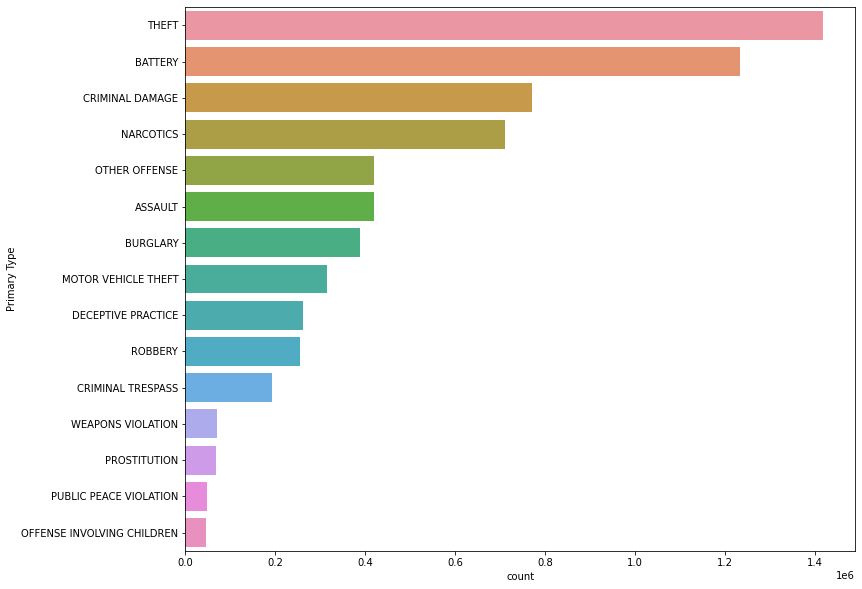

In [ ]:
plt.figure(figsize = (12,10))
sns.countplot(data= chicagodf, y= "Primary Type", order= order)

It can be seen from the plot above that Theft is the highest crime committed of in the city of Chicago closely followed by Battery.

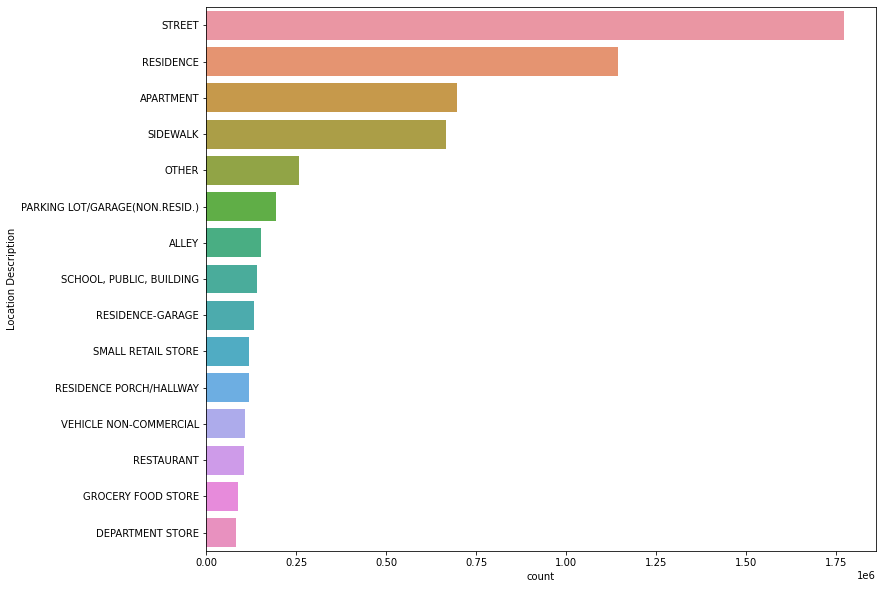

In [ ]:
plt.figure(figsize=(12, 10))
sns.countplot(data = chicagodf, y ='Location Description', order = chicagodf['Location Description'].value_counts().iloc[:15].index)

The most of the crime committed in Chicago happens on the street closely follwed by crimes commited in residence and apartments.



**Forecast Time Series**

In [ ]:
#Resample data to account for occurences in a year
chicagodf.resample('Y').size()

Date
2001-12-31    485749
2002-12-31    486753
2003-12-31    475936
2004-12-31    469381
2005-12-31    453703
2006-12-31    448097
2007-12-31    436999
2008-12-31    427038
2009-12-31    392663
2010-12-31    370290
2011-12-31    351749
2012-12-31    335921
2013-12-31    307030
2014-12-31    275200
2015-12-31    263929
2016-12-31    268813
2017-12-31    267791
2018-12-31    229998
Freq: A-DEC, dtype: int64

Text(0, 0.5, 'Number of Crimes')

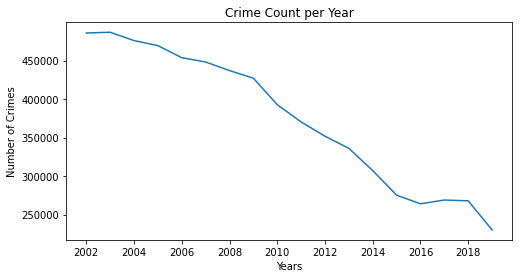

In [ ]:
#Lets visualize the plots for crimes committed over the years
plt.figure(figsize= (8,4))
plt.plot(chicagodf.resample('Y').size())
plt.title('Crime Count per Year')
plt.xlabel('Years')
plt.ylabel('Number of Crimes')

we can observe a drastic reduction in the amount of crime committed yearly right from 2001.

Text(0, 0.5, 'Number of Crimes')

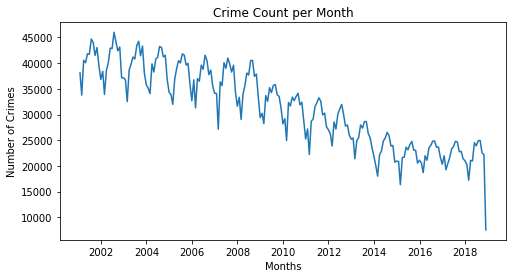

In [ ]:
#Lets Evaluate the monthly thread
plt.figure(figsize= (8,4))
plt.plot(chicagodf.resample('M').size())
plt.title('Crime Count per Month')
plt.xlabel('Months')
plt.ylabel('Number of Crimes')

**Prepare Data For Forecast Using Prophet**

In [52]:
chicagodf_prop = chicagodf.resample('M').size().reset_index()

In [53]:
chicagodf_prop

,Date,0
0,2001-01-31,38097
1,2001-02-28,33779
2,2001-03-31,40553
3,2001-04-30,40080
4,2001-05-31,41821
...,...,...
210,2018-07-31,24878
211,2018-08-31,24955
212,2018-09-30,22551
213,2018-10-31,22179


In [56]:
chicagodf_prop.columns = ['Date', 'Crime Count']

In [57]:
chicagodf_prop

,Date,Crime Count
0,2001-01-31,38097
1,2001-02-28,33779
2,2001-03-31,40553
3,2001-04-30,40080
4,2001-05-31,41821
...,...,...
210,2018-07-31,24878
211,2018-08-31,24955
212,2018-09-30,22551
213,2018-10-31,22179


In [59]:
chicagodf_prop = chicagodf_prop.rename(columns = {'Date': 'ds', 'Crime Count': 'y'})

In [60]:
chicagodf_prop

,ds,y
0,2001-01-31,38097
1,2001-02-28,33779
2,2001-03-31,40553
3,2001-04-30,40080
4,2001-05-31,41821
...,...,...
210,2018-07-31,24878
211,2018-08-31,24955
212,2018-09-30,22551
213,2018-10-31,22179


In [61]:
#Employing Prophet to model the data
m = Prophet()
m.fit(chicagodf_prop)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [62]:
#Creating a dataframe of prediction for the next 365 days
future =m.make_future_dataframe(periods = 365)
forecast = m.predict(future)

In [63]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2001-01-31,41684.254930,36800.292069,40153.057098,41684.254930,41684.254930,-3228.167218,-3228.167218,-3228.167218,-3228.167218,-3228.167218,-3228.167218,0.0,0.0,0.0,38456.087711
1,2001-02-28,41629.678378,33912.577585,37207.348611,41629.678378,41629.678378,-6048.284247,-6048.284247,-6048.284247,-6048.284247,-6048.284247,-6048.284247,0.0,0.0,0.0,35581.394131
2,2001-03-31,41569.254339,38955.354549,42090.128008,41569.254339,41569.254339,-1070.060137,-1070.060137,-1070.060137,-1070.060137,-1070.060137,-1070.060137,0.0,0.0,0.0,40499.194203
3,2001-04-30,41510.779463,38964.107482,42220.900977,41510.779463,41510.779463,-948.027045,-948.027045,-948.027045,-948.027045,-948.027045,-948.027045,0.0,0.0,0.0,40562.752418
4,2001-05-31,41450.355424,41456.797210,44660.045711,41450.355424,41450.355424,1593.580007,1593.580007,1593.580007,1593.580007,1593.580007,1593.580007,0.0,0.0,0.0,43043.935431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,2019-11-26,20379.523627,11362.077079,14625.654483,20282.142146,20468.503872,-7486.879615,-7486.879615,-7486.879615,-7486.879615,-7486.879615,-7486.879615,0.0,0.0,0.0,12892.644012
576,2019-11-27,20377.830047,12342.747770,15625.458859,20279.910358,20467.263792,-6474.025517,-6474.025517,-6474.025517,-6474.025517,-6474.025517,-6474.025517,0.0,0.0,0.0,13903.804530
577,2019-11-28,20376.136468,13326.790797,16568.063654,20277.678570,20466.023712,-5353.728887,-5353.728887,-5353.728887,-5353.728887,-5353.728887,-5353.728887,0.0,0.0,0.0,15022.407581
578,2019-11-29,20374.442888,14667.536602,17934.638010,20275.446782,20464.783631,-4136.445522,-4136.445522,-4136.445522,-4136.445522,-4136.445522,-4136.445522,0.0,0.0,0.0,16237.997366


Prophet has been able to predict a dataframe of predicted trend of crime count for the next 365 days.
lets look to visualize the trend.

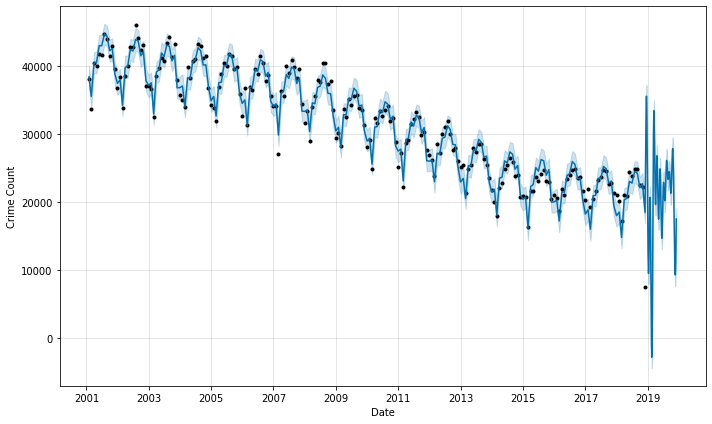

In [64]:
figure = m.plot(forecast, xlabel= 'Date', ylabel = 'Crime Count')

The plots above showed a downward trend in the rate of crime committed in the city of Chicago and the trend is predicted to continue in the next 365 days.

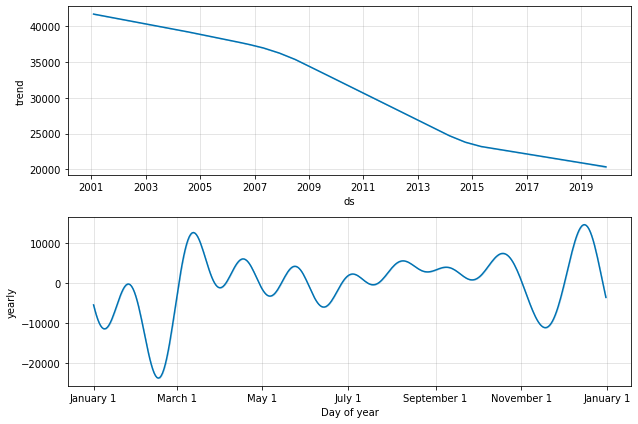

In [65]:
figure = m.plot_components(forecast)

The components plots of the predicted trend shows quite a steady trend in the amount of crimes committed from April down to october while the crime rate declines within the winter periods.